# Overview
This is my own attempt to predict wine quality, but using a categorical perceptron. I do this by having an output as wide as the input - and then use some helper functions to turn the quality metric into a integer bitmap, and back again.

In [1]:
# Load our primary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [3]:
# Load raw data
red_file = 'winequality-red.csv'
white_file = 'winequality-white.csv'

# Read in white wine data 
white = pd.read_csv(white_file, sep=';')

# Read in red wine data 
red = pd.read_csv(red_file, sep=';')

print(red.shape)
print(white.shape)

# Let's build a single data set, with type distinguishing between red and white wine

# Add `type` column to `red` with value 1
red['type'] = 1

# Add `type` column to `white` with value 0
white['type'] = 0

# Append `white` to `red`
# We ignore the white index, and instead extend the red index
wines = red.append(white, ignore_index=True)

(1599, 12)
(4898, 12)


In [9]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# That is a nifty function - I prefer tolist() for clarity
y = wines['quality'].tolist()

# Specify the data - nifty drop function
X = wines.drop('quality', axis=1)

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

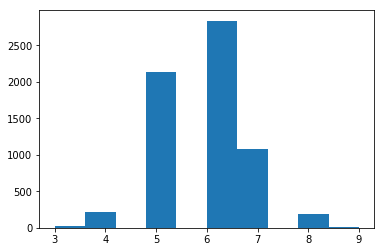

In [10]:
# Quickly check histogram
plt.hist(y, bins=10)
plt.show()

In [11]:
# scale our test and train data
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

X=StandardScaler().fit_transform(X)

# We also need to make our y categorical
from keras.utils import to_categorical
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

In [12]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(64, activation='relu', input_dim=12))

# Add one hidden layer 
model.add(Dense(64, activation='relu'))

# Add an output layer 
model.add(Dense(10, activation='sigmoid'))

In [13]:
# Whoop whoop - now lets model!
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=20, batch_size=1, verbose=1)

Epoch 1/20
4352/4352 [==============================] - 17s 4ms/step - loss: 1.6779 - acc: 0.2266
Epoch 2/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.4673 - acc: 0.4051
Epoch 3/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.2787 - acc: 0.4269
Epoch 4/20
4352/4352 [==============================] - 17s 4ms/step - loss: 1.2524 - acc: 0.4359
Epoch 5/20
4352/4352 [==============================] - 17s 4ms/step - loss: 1.2081 - acc: 0.4793
Epoch 6/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.1811 - acc: 0.4908
Epoch 7/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.1600 - acc: 0.5037
Epoch 8/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.1520 - acc: 0.4920
Epoch 9/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.1440 - acc: 0.5030
Epoch 10/20
4352/4352 [==============================] - 18s 4ms/step - loss: 1.1330 - acc: 0.5097
Epoch 11/20
4352/43

In [14]:
y_pred = model.predict(X_test)
y_pred_binary = y_pred.round()

score = model.evaluate(X_test, y_test,verbose=1)
print(score)

2145/2145 [==============================] - 0s 51us/step
[1.095790630954129, 0.52214452214452212]


In [15]:
# turn categorical logic array into an integer
def cat_to_int(length, arr_of_arr):
    result = []
    for arr in arr_of_arr:
        total = 0
        count = 1
        for i in range(length):
            if arr[i] > 0:
                if total > 0:
                    count += 1
                total += (i+1) * arr[i]
        if count > 1:
            # take average if more than one picked
            total = total/count
        result.append(total)
    return result

data = [[1,0,0,0],
        [0,1,0,0],
        [0,0,1,0],
        [0,0,0,1],
        [1,1,0,0],
        [0,0,1,1]]

print(cat_to_int(4, data))

[1, 2, 3, 4, 1.5, 3.5]


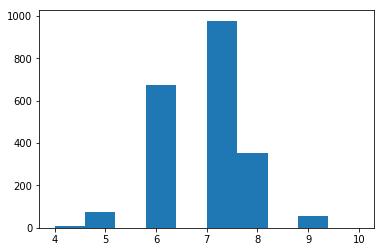

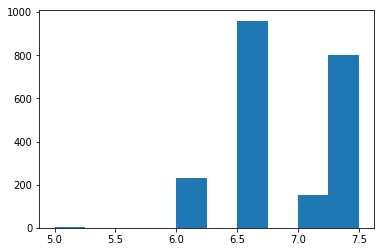

In [16]:
y_test_int = cat_to_int(10, y_test)
plt.hist(y_test_int)
plt.show()

y_pred_int = cat_to_int(10, y_pred_binary)
plt.hist(y_pred_int)
plt.show()

quality    10.0
dtype: float64
quality    7.5
dtype: float64
quality    4.0
dtype: float64
quality    5.0
dtype: float64


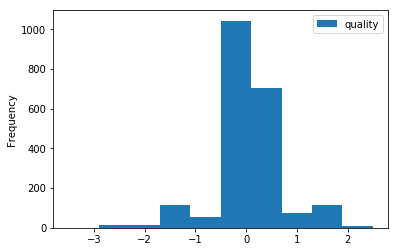

In [17]:
arr_test = pd.DataFrame({'quality': y_test_int})
arr_pred = pd.DataFrame({'quality': y_pred_int})

print(arr_test.max())
print(arr_pred.max())

print(arr_test.min())
print(arr_pred.min())

# measure per sample error
differences = arr_test-arr_pred
differences.plot(kind='hist')

Still not great - but a slightly better spread of innaccuracies, rather than a massive amount of undecided 'all zeros'.

This model is MUCH slower though - it makes more sense to see quality as a continious regression prediction. Then the perceptron is dealing with a single output, and it can use continuious functions throughout.